# About this project:

This project aims to train a neural network model to identify the presence of COVID-19 from images of Chest X-Rays. A model that works well would be useful for accelerating the identification of infected individuals, especially in countries where hospitals are overwhelmed and lacking trained doctors to make diagnoses.


## Dataset information:


The dataset was downloaded from Kaggle: https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset


## Content

The dataset contains ~5800 jpeg images of Chest X-Rays of Healthy patients, as well as patients affected with Pneumonia. The pneumonia X-Rays contain cases of bacterial infections as well as viral infections, such as SARS (Severe Acute Respiratory Syndrome ) ,Streptococcus & ARDS (Acute Respiratory Distress Syndrome).


## Acknowledgements

This analysis is made possible by the dataset compiled by Joseph Paul Cohen. Postdoctoral Fellow, Mila, University of Montreal.

Original Source :- https://github.com/ieee8023/covid-chestxray-dataset

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import PIL

#For organizing image folders
import shutil
import os

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization

# Ensure we use GPU for faster neural network training

Note: For this notebook we create a virtual environment with the tensorflow-gpu package instead of the usual tensorflow. This ensures GPU usage for training instead of CPU. 

Documentation: https://www.tensorflow.org/install/gpu

In [2]:
from tensorflow.python.client import device_lib

#List devices detected by Tensorflow:

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2517350819853874321,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2255607338174305924
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7046801664
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4057996933204508442
 physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17739806022366750350
 physical_device_desc: "device: XLA_GPU device"]

In [3]:
print('Making sure GPU is available:')
print("GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print('GPU Name:', tf.config.list_physical_devices('GPU'))

Making sure GPU is available:
GPUs Available:  1
GPU Name: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Import data

In [4]:
# os.mkdir('./Data/')

In [5]:
df = pd.read_csv('./Data/Chest_xray_Corona_Metadata.csv', index_col = 0)

df_train = df[df['Dataset_type'] == 'TRAIN']
df_test = df[df['Dataset_type'] == 'TEST']

print('Training data shape:', df_train.shape)
print('Testing data shape:', df_test.shape)

#Looking at metadata:

df_train.head()

Training data shape: (5286, 5)
Testing data shape: (624, 5)


,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [6]:
#The dataset also contains a csv file of the summary counts:
summary = pd.read_csv('./Data/Chest_xray_Corona_dataset_Summary.csv', index_col = 0)
summary

,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,Normal,NaN,NaN,1576
1,Pnemonia,Stress-Smoking,ARDS,2
2,Pnemonia,Virus,NaN,1493
3,Pnemonia,Virus,COVID-19,58
4,Pnemonia,Virus,SARS,4
5,Pnemonia,bacteria,NaN,2772
6,Pnemonia,bacteria,Streptococcus,5


All the images will be used for analysis except the non-viral, Stress-Smoking images, as there are only 2 of those.

# Preparing the image data by rearranging the directories:

### Making new folders for Healthy (Pneumonia-free) X-Rays:

In [7]:
#Get list of all filenames

all_filenames_test = os.listdir('./Pictures/test')
all_filenames_train = os.listdir('./Pictures/train')

#Get list of filenames for the 'Normal' or healthy X-rays

normal_filenames_test = list(df_test[df_test['Label'] == 'Normal']['X_ray_image_name'])
normal_filenames_train = list(df_train[df_train['Label'] == 'Normal']['X_ray_image_name'])

print('No. of Normal X-rays (training):',len(normal_filenames_train))
print('No. of Normal X-rays (testing):',len(normal_filenames_test))

No. of Normal X-rays (training): 1342
No. of Normal X-rays (testing): 234


In [8]:
#Moving normal x-ray files to new folders:




#Move files into new folder (testing)
'''

#os.makedirs('./Pictures/test/normal')


for filename in normal_filenames_test:
    shutil.move(src = './Pictures/test/{}'.format(filename),
                dst = './Pictures/test/normal/{}'.format(filename)
               )
'''
    
#Move files into new folder (training)

'''
os.makedirs('./Pictures/train/normal')

for filename in normal_filenames_train:
    shutil.move(src = './Pictures/train/{}'.format(filename),
                dst = './Pictures/train/normal/{}'.format(filename)
               )
               
'''

"\nos.makedirs('./Pictures/train/normal')\n\nfor filename in normal_filenames_train:\n    shutil.move(src = './Pictures/train/{}'.format(filename),\n                dst = './Pictures/train/normal/{}'.format(filename)\n               )\n               \n"

### Making new folders for Pneumonia (bacterial) infections:

In [9]:

#Get list of filenames for the bacterial infection X-rays

bacteria_filenames_test = list(df_test[df_test['Label_1_Virus_category'] == 'bacteria']['X_ray_image_name'])
bacteria_filenames_train = list(df_train[df_train['Label_1_Virus_category'] == 'bacteria']['X_ray_image_name'])

print('No. of Bacterial Infection X-rays (training):',len(bacteria_filenames_train))
print('No. of Bacterial Infection X-rays (testing):',len(bacteria_filenames_test))

No. of Bacterial Infection X-rays (training): 2535
No. of Bacterial Infection X-rays (testing): 242


In [10]:
#Moving bacteria x-ray files to new folders:



#Move files into new folder (testing)

'''
os.makedirs('./Pictures/test/bacteria')


for filename in bacteria_filenames_test:
    shutil.move(src = './Pictures/test/{}'.format(filename),
                dst = './Pictures/test/bacteria/{}'.format(filename)
               )

'''


#Move files into new folder (training)

'''
os.makedirs('./Pictures/train/bacteria')

for filename in bacteria_filenames_train:
    shutil.move(src = './Pictures/train/{}'.format(filename),
                dst = './Pictures/train/bacteria/{}'.format(filename)
               )         
'''

"\nos.makedirs('./Pictures/train/bacteria')\n\nfor filename in bacteria_filenames_train:\n    shutil.move(src = './Pictures/train/{}'.format(filename),\n                dst = './Pictures/train/bacteria/{}'.format(filename)\n               )         \n"

### Making new folder for Pneumonia (Viral, COVID-19) infections:

In [11]:

#Get list of filenames for the bacterial infection X-rays

covid_filenames_test = list(df_test[df_test['Label_2_Virus_category'] == 'COVID-19']['X_ray_image_name'])
covid_filenames_train = list(df_train[df_train['Label_2_Virus_category'] == 'COVID-19']['X_ray_image_name'])

print('No. of COVID-19 Infection X-rays (training):',len(covid_filenames_train))
print('No. of COVID-19 Infection X-rays (testing):',len(covid_filenames_test))


No. of COVID-19 Infection X-rays (training): 58
No. of COVID-19 Infection X-rays (testing): 0


### There are no COVID-19 X-rays in the testing folder, so we will move some there

In [12]:
#Moving covid-19 x-ray files to new folders:



#Move files into new folder (testing)

'''
# os.makedirs('./Pictures/test/covid-19')

for filename in covid_filenames_train[:8]:
    shutil.move(src = './Pictures/train/{}'.format(filename),
                dst = './Pictures/test/covid-19/'
               )
'''



#Move files into new folder (training)

'''
os.makedirs('./Pictures/train/covid-19')

for filename in covid_filenames_train[8:]:
    shutil.move(src = './Pictures/train/{}'.format(filename),
                dst = './Pictures/train/covid-19/'
               )         
'''

"\nos.makedirs('./Pictures/train/covid-19')\n\nfor filename in covid_filenames_train[8:]:\n    shutil.move(src = './Pictures/train/{}'.format(filename),\n                dst = './Pictures/train/covid-19/'\n               )         \n"

### Making new folder for Pneumonia (Viral, non-COVID) infections:

In [13]:
#Get list of filenames for the bacterial infection X-rays

virus_noncovid_filenames_test = list(df_test.loc[(df_test['Label_2_Virus_category'] != 'COVID-19' )
                                        & 
                                        (df_test['Label_1_Virus_category'] == 'Virus')
                                        ]['X_ray_image_name']
                           )

virus_noncovid_filenames_train = list(df_train.loc[(df_train['Label_2_Virus_category'] != 'COVID-19' )
                                        & 
                                        (df_train['Label_1_Virus_category'] == 'Virus')
                                        ]['X_ray_image_name']
                           )

print('No. of Viral Infection X-rays (training):',len(virus_noncovid_filenames_train))
print('No. of Viral Infection X-rays (testing):',len(virus_noncovid_filenames_test))


No. of Viral Infection X-rays (training): 1349
No. of Viral Infection X-rays (testing): 148


In [14]:
#Moving viral (non-covid) x-ray files to new folders:



#Move files into new folder (testing)

'''
os.makedirs('./Pictures/test/virus(non-covid)')

for filename in virus_noncovid_filenames_test:
    shutil.move(src = './Pictures/test/{}'.format(filename),
                dst = './Pictures/test/virus(non-covid)/'
               )
'''

#Move files into new folder (training)


'''
os.makedirs('./Pictures/train/virus(non-covid)')

for filename in virus_noncovid_filenames_train:
    shutil.move(src = './Pictures/train/{}'.format(filename),
                dst = './Pictures/train/virus(non-covid)/'
               )         
'''

"\nos.makedirs('./Pictures/train/virus(non-covid)')\n\nfor filename in virus_noncovid_filenames_train:\n    shutil.move(src = './Pictures/train/{}'.format(filename),\n                dst = './Pictures/train/virus(non-covid)/'\n               )         \n"

This is what the data folder structure for the pictures looks like now:

In [15]:
#Visualize the picture folder

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        
            
list_files('./Pictures')

Pictures/
    test/
        bacteria/
        covid-19/
        normal/
        virus(non-covid)/
    train/
        bacteria/
        covid-19/
        normal/
        virus(non-covid)/


In [16]:
#Note: There were 25 images in the training set with no metadata. They were deleted from the folder.

# Loading an example image

In [17]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

In [18]:
summary

,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,Normal,NaN,NaN,1576
1,Pnemonia,Stress-Smoking,ARDS,2
2,Pnemonia,Virus,NaN,1493
3,Pnemonia,Virus,COVID-19,58
4,Pnemonia,Virus,SARS,4
5,Pnemonia,bacteria,NaN,2772
6,Pnemonia,bacteria,Streptococcus,5


The dataset is imbalanced with very few samples for COVID-19 infections. Class weights will be implemented later in the model to address the imbalance.

### Seeing some example images:

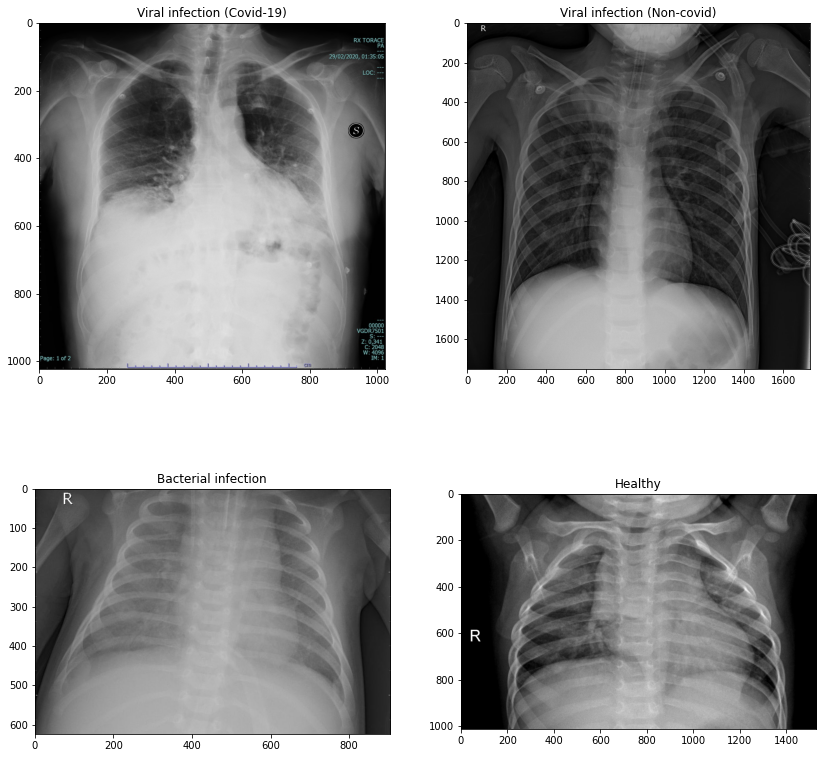

In [19]:
#Getting some sample images

normal = df_train[df_train['Label'] == 'Normal']['X_ray_image_name'].iloc[0]
bacteria = df_train[df_train['Label_1_Virus_category'] == 'bacteria']['X_ray_image_name'].iloc[0]
virus_covid = df_train[df_train['Label_2_Virus_category'] == 'COVID-19']['X_ray_image_name'].iloc[10]
virus_noncovid = df_train[(df_train['Label_2_Virus_category'] != 'COVID-19')
                          &
                          (df_train['Label_1_Virus_category'] == 'Virus')]['X_ray_image_name'].iloc[0]


covid_img = load_img('./Pictures/train/covid-19/{}'.format(virus_covid))
virus_noncovid_img = load_img('./Pictures/train/virus(non-covid)/{}'.format(virus_noncovid))
bacteria_img = load_img('./Pictures/train/bacteria/{}'.format(bacteria))
normal_img = load_img('./Pictures/train/normal/{}'.format(normal))



#Plotting the images

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (14,14))



ax[0][0].imshow(covid_img)
ax[0][0].set_title('Viral infection (Covid-19)')

ax[0][1].imshow(virus_noncovid_img)
ax[0][1].set_title('Viral infection (Non-covid)')

ax[1][0].imshow(bacteria_img)
ax[1][0].set_title('Bacterial infection')

ax[1][1].imshow(normal_img)
ax[1][1].set_title('Healthy')


plt.show()

# Doing image augmentation

There are only 58 images of COVID-19 labelled X-rays in our dataset which is tragic, so we will attempt to some image augmentation.

Here we will try to artificially generate images so we can have a larger training dataset. First we decide what kind of image transformations will be appropriate, and then proceed with the generation.

In [20]:
#Import libraries

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, array_to_img

### Horizontal image shifting

In [21]:
img_array = img_to_array(covid_img)

img_array.shape

(1024, 1024, 3)

In [22]:
img_array_exp = np.expand_dims(img_array, 0)

img_array_exp.shape

(1, 1024, 1024, 3)

In [23]:
imagegen = ImageDataGenerator(width_shift_range = 0.2)

iterator = imagegen.flow(img_array_exp)

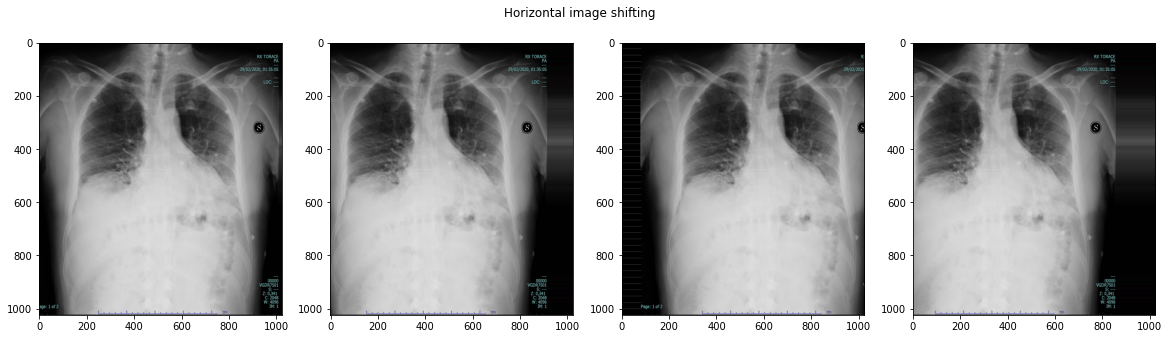

In [24]:
#Plotting a few example images of horizontal shifting

fig, ax = plt.subplots(nrows = 1, ncols =4, 
                           figsize = (20,5))

for i in range(4):

    ax[i].imshow(array_to_img(x = iterator.next()[0],
                             scale = False),
                 aspect = 'auto')
    
fig.suptitle('Horizontal image shifting')
plt.show()

### Vertical image shifting


In [25]:
imagegen = ImageDataGenerator(height_shift_range = 0.2)

iterator = imagegen.flow(img_array_exp)

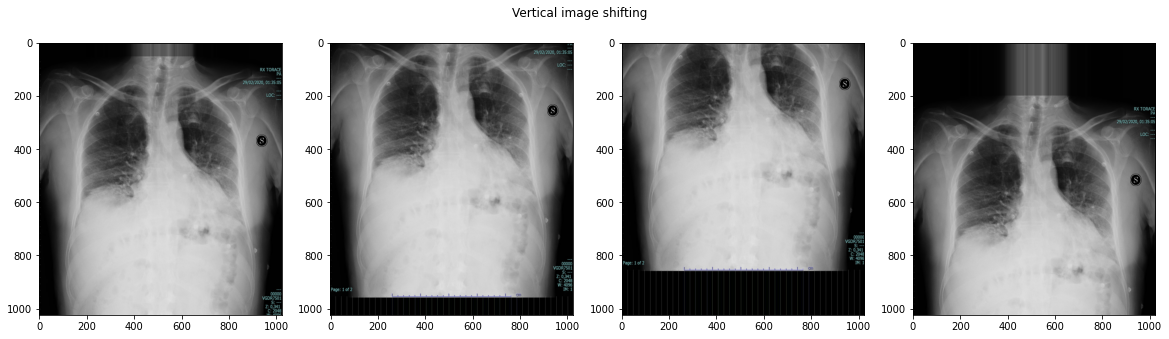

In [26]:
#Plotting a few example images of horizontal shifting

fig, ax = plt.subplots(nrows = 1, ncols =4, 
                           figsize = (20,5))

for i in range(4):

    ax[i].imshow(array_to_img(x = iterator.next()[0],
                             scale = False),
                 aspect = 'auto')
    
fig.suptitle('Vertical image shifting')
plt.show()

### Horizontal flipping:

In [27]:
imagegen = ImageDataGenerator(horizontal_flip = True)

iterator = imagegen.flow(img_array_exp)

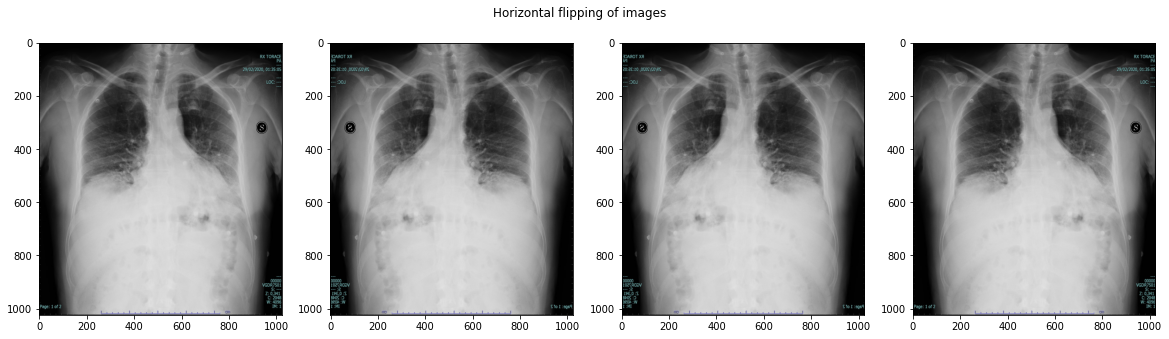

In [28]:
#Plotting a few example images of horizontal shifting

fig, ax = plt.subplots(nrows = 1, ncols =4, 
                           figsize = (20,5))

for i in range(4):

    ax[i].imshow(array_to_img(x = iterator.next()[0],
                             scale = False),
                 aspect = 'auto')
    
fig.suptitle('Horizontal flipping of images')
plt.show()

Vertical flipping would not be realistic for X-ray images so we exclude that. Therefore we will use these 3 image transformations to generate new data. 

# Load images into keras image generators

In [29]:
#Prepare our generator

generator = ImageDataGenerator(width_shift_range = 0.2,
                               height_shift_range = 0.2,
                               horizontal_flip = True)

In [196]:
train_generator = generator.flow_from_directory(directory = './Pictures/train',
                                                class_mode = 'categorical',
                                                color_mode = 'grayscale',
                                                batch_size = 16)

test_generator = generator.flow_from_directory(directory = './Pictures/test',
                                                class_mode = 'categorical',
                                                color_mode = 'grayscale')

Found 5276 images belonging to 4 classes.
Found 632 images belonging to 4 classes.


In [130]:
#Old code without image generation



from keras.preprocessing import image_dataset_from_directory

training_ds = image_dataset_from_directory(directory = './Pictures/train',
                                           label_mode = 'categorical',
                                           color_mode = 'grayscale',
                                           batch_size = 8)
testing_ds = image_dataset_from_directory(directory = './Pictures/test',
                                           label_mode = 'categorical',
                                           color_mode = 'grayscale')


Found 5276 files belonging to 4 classes.
Found 632 files belonging to 4 classes.


### Preparing class weights for model fitting:

In [117]:
#Put the class counts in to a dictionary:

classes = os.listdir('./Pictures/train')
classes.remove('desktop.ini')

class_count = dict()

for i in classes:
    class_count[i] = len(os.listdir('./Pictures/train/{}'.format(i)))

class_count

{'bacteria': 2536, 'covid-19': 51, 'normal': 1343, 'virus(non-covid)': 1350}

In [118]:
#Compute class weights:

total_sum = sum(class_count.values())

class_weights = {label: 1/(count/total_sum) for label, count in enumerate(class_count.values())}

#Check output:

class_weights

{0: 2.082018927444795,
 1: 103.52941176470588,
 2: 3.9314966492926287,
 3: 3.911111111111111}

In [119]:
#Weight for covid-19 cases (label 1) is a little high so we can adjust it downwards

In [120]:
class_weights[1] = 20.0

In [121]:
class_weights

{0: 2.082018927444795, 1: 20.0, 2: 3.9314966492926287, 3: 3.911111111111111}

### Make model

In [122]:
from keras.layers import Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPool2D
from keras.models import Sequential, load_model
from keras.metrics import AUC, Precision, Recall
from keras.optimizers import Adam

In [138]:
# model = load_model('./Models/Model_four_with_augmentation')

In [190]:
model = Sequential()

#Stage 1
model.add(Conv2D(filters = 64, kernel_size = (3,3), 
                 input_shape = (256,256,1), #Provide input shape for first layer!
                 #kernel_regularizer=keras.regularizers.l1(0.01), #Regularization to prevent overfitting
                 activation = 'relu', 
                 padding = 'valid')) #Zero pad the borders 
model.add(Conv2D(filters = 64, kernel_size = (3,3), 
                 #kernel_regularizer=keras.regularizers.l1(0.01),
                 activation = 'relu',
                 padding = 'valid'))
model.add(MaxPool2D(pool_size = (2,2),
                    strides = (1,1) )) #Pooling to accelerate learning

#model.add(Dropout(0.4)) #Dropout to prevent overfitting


#Stage 2
model.add(Conv2D(filters = 128, kernel_size = (3,3), 
                 #kernel_regularizer=keras.regularizers.l1(0.01),
                 activation = 'relu',
                 padding = 'valid'))
'''           
model.add(Conv2D(filters = 128, kernel_size = (3,3), 
                 #kernel_regularizer=keras.regularizers.l1(0.01),
                 activation = 'relu',
                 padding = 'valid'))
model.add(MaxPool2D(pool_size = (3,3))) 
#model.add(Dropout(0.4)) 


#Stage 3
model.add(Conv2D(filters = 256, kernel_size = (3,3), 
                 activation = 'relu',
                 padding = 'valid'))
model.add(Conv2D(filters = 256, kernel_size = (3,3), 
                 #kernel_regularizer=keras.regularizers.l1(0.01),
                 activation = 'relu',
                 padding = 'valid'))
model.add(Conv2D(filters = 256, kernel_size = (3,3), 
                 #kernel_regularizer=keras.regularizers.l1(0.01),
                 activation = 'relu',
                 padding = 'valid'))
model.add(MaxPool2D(pool_size = (2,2))) 
#model.add(Dropout(0.4))


#Stage 4
model.add(Conv2D(filters = 512, kernel_size = (3,3), 
                 #kernel_regularizer=keras.regularizers.l1(0.01),
                 activation = 'relu',
                 padding = 'valid'))
model.add(Conv2D(filters = 512, kernel_size = (3,3), 
                 #kernel_regularizer=keras.regularizers.l1(0.01),
                 activation = 'relu',
                 padding = 'valid'))
model.add(Conv2D(filters = 512, kernel_size = (3,3), 
                 #kernel_regularizer=keras.regularizers.l1(0.01),
                 activation = 'relu',
                 padding = 'valid'))
model.add(MaxPool2D(pool_size = (2,2))) 



#Layer 4
model.add(Conv2D(filters = 512, kernel_size = (3,3), 
                 #kernel_regularizer=keras.regularizers.l1(0.01),
                 activation = 'relu',
                 padding = 'valid'))
model.add(Conv2D(filters = 512, kernel_size = (3,3), 
                 #kernel_regularizer=keras.regularizers.l1(0.01),
                 activation = 'relu',
                 padding = 'valid'))
model.add(Conv2D(filters = 512, kernel_size = (3,3), 
                 #kernel_regularizer=keras.regularizers.l1(0.01),
                 activation = 'relu',
                 padding = 'valid'))
#model.add(MaxPool2D(pool_size = (2,2))) 
model.add(Dropout(0.4))


#Layer 5
model.add(Conv2D(filters = 128, kernel_size = (3,3), 
                 kernel_regularizer=keras.regularizers.l1(0.01),
                 activation = 'relu',
                 padding = 'valid'))
#model.add(MaxPool2D(pool_size = (2,2))) 
model.add(Dropout(0.4)) 
'''

#Flatten outputs before dense layers
#model.add(Dropout(0.2))
model.add(Flatten())

#A couple of dense layers
#model.add(Dense(10, activation = 'relu'))
#model.add(Dense(100, activation = 'relu'))

#Dense layer for decision output
model.add(Dense(4, activation = 'softmax'))


In [191]:
model.compile(optimizer = Adam(learning_rate = 0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
             metrics = ['accuracy', AUC(), Precision(), Recall()])

In [192]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_175 (Conv2D)          (None, 254, 254, 64)      640       
_________________________________________________________________
conv2d_176 (Conv2D)          (None, 252, 252, 64)      36928     
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 251, 251, 64)      0         
_________________________________________________________________
conv2d_177 (Conv2D)          (None, 249, 249, 128)     73856     
_________________________________________________________________
flatten_25 (Flatten)         (None, 7936128)           0         
_________________________________________________________________
dense_54 (Dense)             (None, 4)                 31744516  
Total params: 31,855,940
Trainable params: 31,855,940
Non-trainable params: 0
_________________________________________

In [ ]:
#Fit the model using augmented images and a scheduler

history = model.fit(x = train_generator, 
                    epochs = 250, 
                    steps_per_epoch= None,
                    #callbacks = scheduler,
                    #class_weight = class_weights
                   )

Epoch 1/250
330/330 [==============================] - 74s 224ms/step - loss: 103.7980 - accuracy: 0.6041 - auc_19: 0.8117 - precision_19: 0.6567 - recall_19: 0.4067
Epoch 2/250
330/330 [==============================] - 71s 216ms/step - loss: 0.8821 - accuracy: 0.6509 - auc_19: 0.8659 - precision_19: 0.7058 - recall_19: 0.4947
Epoch 3/250
330/330 [==============================] - 71s 215ms/step - loss: 0.8534 - accuracy: 0.6554 - auc_19: 0.8740 - precision_19: 0.7154 - recall_19: 0.5212
Epoch 4/250
330/330 [==============================] - 72s 217ms/step - loss: 0.8572 - accuracy: 0.6586 - auc_19: 0.8738 - precision_19: 0.7069 - recall_19: 0.5385
Epoch 5/250
330/330 [==============================] - 73s 221ms/step - loss: 0.8431 - accuracy: 0.6518 - auc_19: 0.8737 - precision_19: 0.7076 - recall_19: 0.5434
Epoch 6/250
330/330 [==============================] - 74s 224ms/step - loss: 0.8266 - accuracy: 0.6617 - auc_19: 0.8810 - precision_19: 0.7117 - recall_19: 0.5572
Epoch 7/250
33

In [136]:
#Create a scheduler to adjust learning rate across epochs

#Define a function to apply a time-based decay to learning rate
#after 100 epochs

def decay(epoch, lr, decayspeed = 0.1):
    if epoch < 100:
        return lr
    else:
        return lr/(1+(decayspeed*epoch))

#Create a scheduler

from keras.callbacks import LearningRateScheduler

scheduler = LearningRateScheduler(decay)

In [ ]:
#Save model

model.save('./Models/Model_six_with_augmentation/', overwrite = False)

In [ ]:
model.evaluate(test_generator)

In [ ]:
#Unlock this cell if it's the first time training the model:

mainhistory = copy.deepcopy(history.history)


In [ ]:
#Unlock this cell if loading previous history file:

#Load main epoch history

'''
with open('./Models/Model_three_with_augmentation/history.p', 'rb') as readingfile:
    mainhistory = pickle.load(readingfile)
    
'''

In [ ]:
#Unlock this cell if updating previous history file:

'''
#Unlock this cell when training the model


#Update main history dictionary with new batch

for key in history.history.keys():
    mainhistory[key].extend(history.history[key])
    
print('{} new entries added to main history dictionary'.format(len(history.history['loss'])))
'''

In [ ]:
#Save main dictionary:


import pickle

with open('./Models/Model_six_with_augmentation/history.p', 'wb') as outfile:
    pickle.dump(mainhistory, outfile)


In [ ]:
#Plot loss over time:

fig, ax = plt.subplots(nrows = 1, ncols = 1,
                       figsize = (15,7))

ax.plot(mainhistory['loss'])

ax.set_title('Losses over epochs')

ax.set_xlabel('Epochs')

ax.set_ylabel('Loss (Categorical Cross-entropy)')

plt.show()

In [ ]:
model.summary()

In [74]:
kamto = load_model('./Models/Model_three_with_augmentation')

In [79]:
kamto.predict_classes(test_generator)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([3, 3, 0, 0, 1, 0, 0, 3, 3, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 3, 0, 3,
       0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 3, 3, 3, 0, 1, 3, 0, 0, 0, 1, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 3, 3, 3, 3, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 3, 0, 1, 3, 0, 3, 1, 0, 0, 0, 3, 0, 3, 3, 3, 3, 3,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 3, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 3, 0, 0, 3, 3, 3, 1, 0, 3, 0,
       3, 3, 0, 3, 0, 0, 0, 3, 3, 3, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 3, 0, 0, 3, 0, 3, 0, 1, 3, 0, 0, 1, 0, 3, 1, 0, 3, 0, 0, 0,
       0, 3, 0, 3, 3, 3, 3, 0, 3, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 3, 3,
       0, 0, 0, 1, 3, 0, 0, 0, 3, 0, 1, 0, 3, 0, 0, 0, 3, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 3, 3, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3,
       0, 3, 0, 3, 3, 0, 0, 1, 3, 3, 0, 3, 3, 3, 3, 3, 0, 0, 3, 0, 1, 0,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 3, 0, 0,
       1, 3, 3, 0, 0, 1, 0, 3, 0, 3, 0, 0, 3, 0, 0,